## Preprocessing Dataframe

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import (KFold, train_test_split)
from matplotlib import cm
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

# Import Data
url = 'https://raw.githubusercontent.com/pgardocki3/ME8813ML/master/HW2/HW2Dataset.csv'
df = pd.read_csv(url)
df.drop('Unnamed: 0', inplace=True, axis=1) 

# Split data into train/test sets
i = 0
j = 15
X = df.iloc[:,i:j]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

# Normalization of input variables
for i in range(1, len(X_train.iloc[0,:])):
    X_train.iloc[:,i-1] = X_train.iloc[:,i-1]/np.max(X_train.iloc[:,i-1])
    
for i in range(1, len(X_test.iloc[0,:])):
    X_test.iloc[:,i-1] = X_test.iloc[:,i-1]/np.max(X_test.iloc[:,i-1])
 


### Determining Clusters

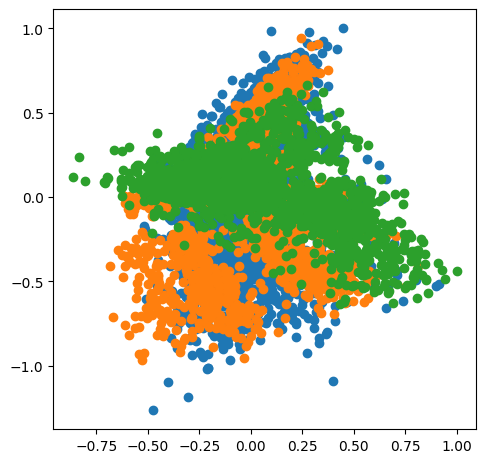

In [4]:
# Choosing the optimal k
k_range = range(1,10)
# Try clustering the data for k values ranging 1 to 10
k_means_var = [KMeans(n_clusters = k, n_init='auto').fit(X_train) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]

k_euclid = [cdist(X_train, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

# Calculate within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# Visualize the elbow method for determining k
#plt.plot(k_range, wcss)
#plt.show()

kmeans = KMeans(n_clusters = 3, n_init='auto', random_state=1)
label = kmeans.fit_predict(X_train)
label1 = kmeans.fit_predict(X_test)
X_train_c0 = X_train[label == 0]
y_train_c0 = y_train[label == 0]
X_train_c1 = X_train[label == 1]
y_train_c1 = y_train[label == 1]
X_train_c2 = X_train[label == 2]
y_train_c2 = y_train[label == 2]

X_test_c0 = X_test[label1 == 0]
y_test_c0 = y_test[label1 == 0]
X_test_c1 = X_test[label1 == 1]
y_test_c1 = y_test[label1 == 1]
X_test_c2 = X_test[label1 == 2]
y_test_c2 = y_test[label1 == 2]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(X_train[label == i].iloc[:,10] , X_train[label == i].iloc[:,3] , label = i)

#ax.scatter(X_train_c0.iloc[:,0],X_train_c0.iloc[:,1],y_train_c0)
#ax = fig.add_subplot(222)      
#ax.scatter(X_test_c0.iloc[:,0],X_test_c0.iloc[:,1],y_test_c0)

## Linear Regression

Mean MAE: 0.819 (0.015)
MSE 9.355791009816638


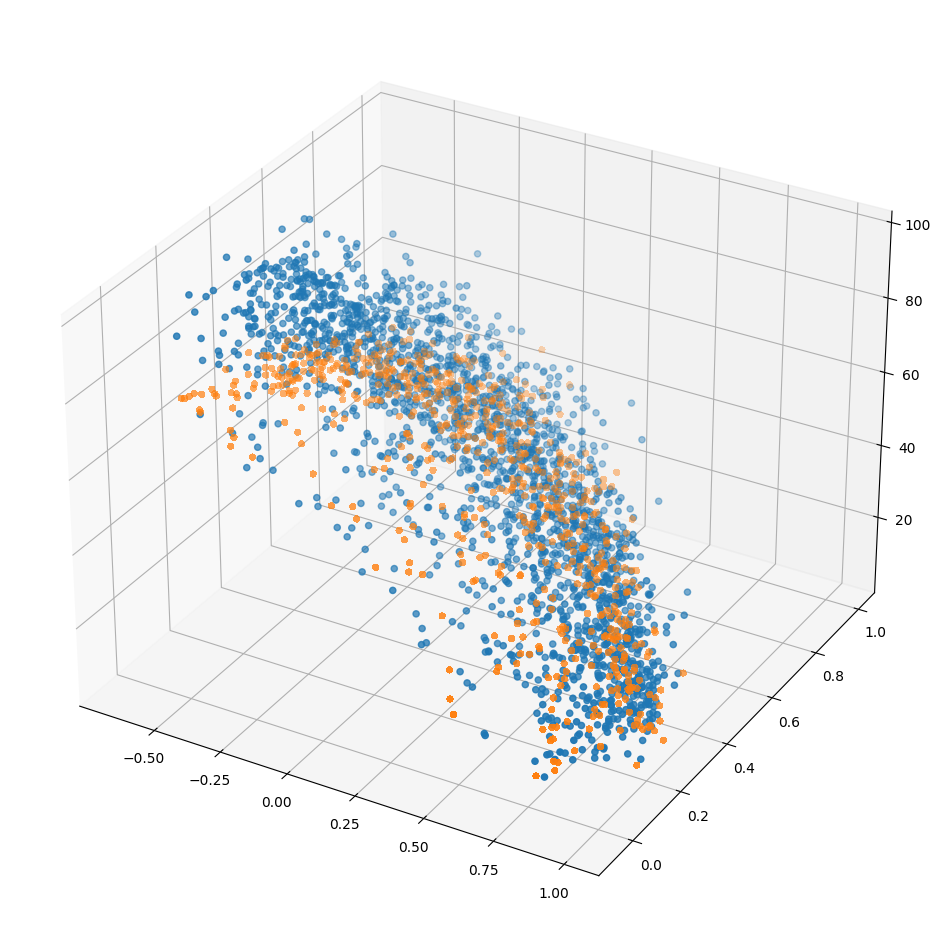

In [5]:
from sklearn import linear_model

# Selecting data
X_train = X_train_c0
y_train = y_train_c0
X_test = X_test_c0
y_test = y_test_c0

model = linear_model.Lasso(alpha=2)
cv = sk.model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = sk.model_selection.cross_val_score(model,X_train, y_train, cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss = mse(y_test,y_pred, squared=False)
print('MSE', loss)
# print("* Model coefficients:")
# print("  w0:", model.intercept_)
# print("  w1:", model.coef_[0])

# Plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train.iloc[:,0],X_train.iloc[:,1],y_train,label='data')
ax.scatter(X_test.iloc[:,0],X_test.iloc[:,1],y_pred.reshape(-1,1),
                       linewidth=0, antialiased=False)

plt.show();


## Gaussian Process Regression

/Users/patrickgardocki/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: invalid value encountered in log
  return np.log(np.vstack(bounds))


MSE 4.975905861253332
RBF Lengthscale: RBF(length_scale=[0.12, 0.573, 0.768, 1.38, 0.546, 1.37, 0.503, 3.46, 1.17, 2.77, 0.515, 1.33, 1.24, 2.29, 0.556])


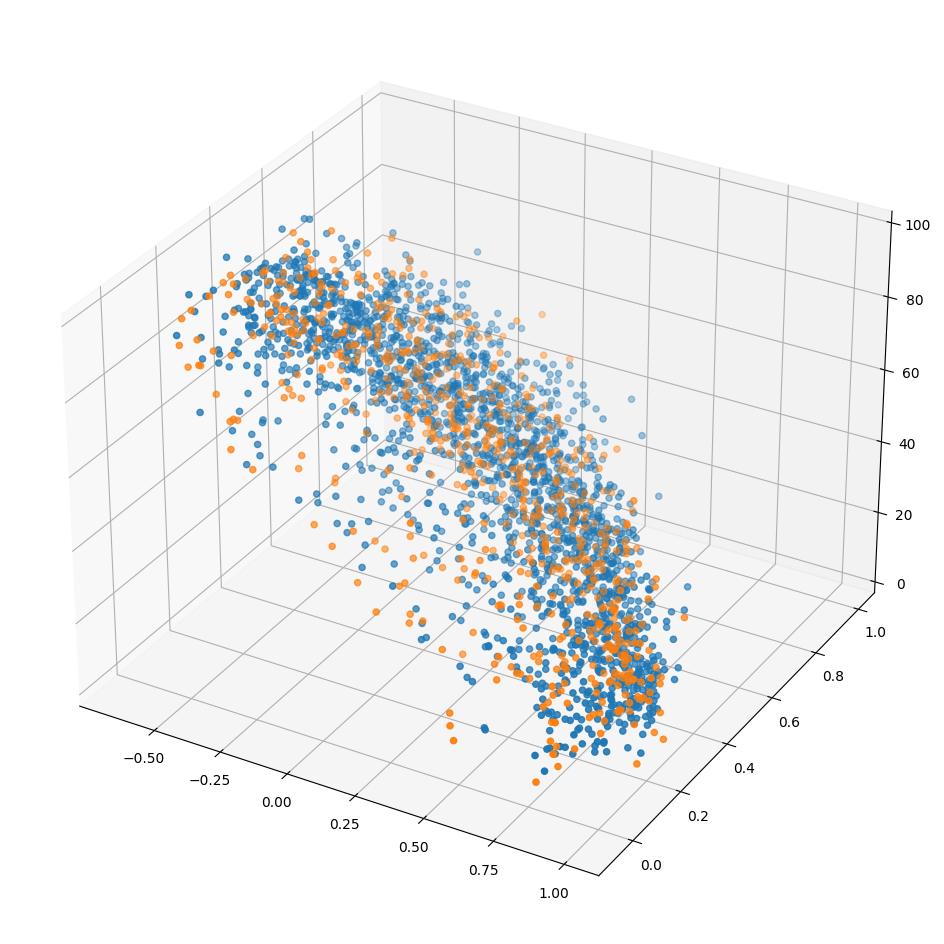

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Exponentiation
from sklearn.model_selection import cross_val_score

# Selecting data
X_train = X_train_c0
y_train = y_train_c0
X_test = X_test_c0
y_test = y_test_c0
length = np.ones(15)
lengths = np.asarray(tuple((-1e-5,1e5) for i in range(15)))

kernel = RBF(length_scale=length,length_scale_bounds=lengths)
        
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gpr.fit(X_train, y_train)
y_pred = gpr.predict(X_test)
#score = cross_val_score(gpr,X_test_c0, y_test_c0, cv=5)
#print(score)
loss = mse(y_test,y_pred, squared=False)
print('MSE', loss)
print(f"RBF Lengthscale: {gpr.kernel_}")

# Plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train.iloc[:,0],X_train.iloc[:,1],y_train,label='data')
ax.scatter(X_test.iloc[:,0],X_test.iloc[:,1],y_pred.reshape(-1,1))

plt.show()

# Variable Importance Measure
#for i 
#https://ema.drwhy.ai/featureImportance.html 

## ANN

22/22 [==============================] - 0s 1ms/step
MSE 3.6597292672129975


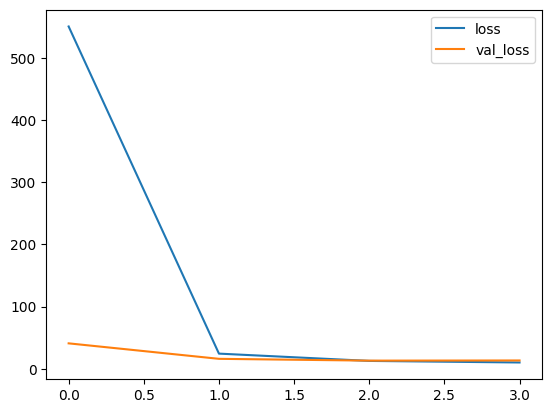

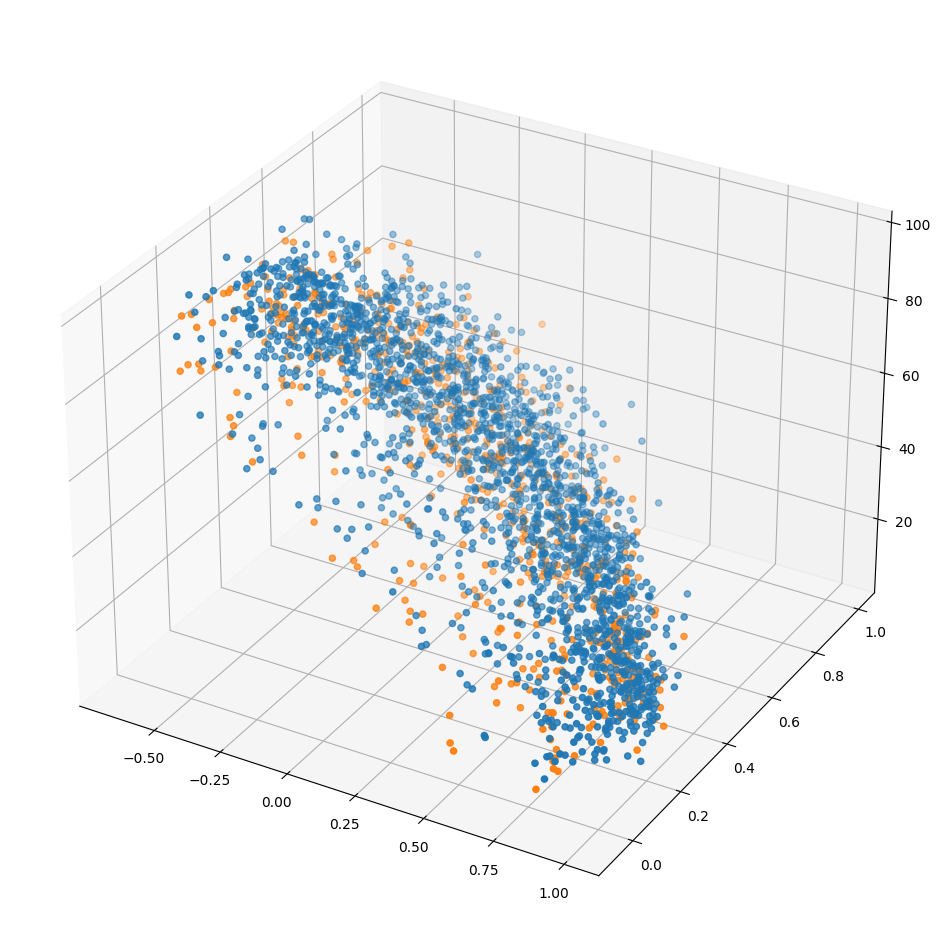

In [68]:
import tensorflow as tf
# MSE 4.975905861080728
# RBF Lengthscale: RBF(length_scale=[0.12, 0.573, 0.768, 1.38, 0.546,
#     1.37, 0.503, 3.46, 1.17, 2.77, 0.515, 1.33, 1.24, 2.29, 0.556])
# Selecting data
X_train = X_train_c0
y_train = y_train_c0
X_test = X_test_c0
y_test = y_test_c0

input_shape = [X_train.shape[1]]
model = tf.keras.Sequential([
    tf.keras.Input(shape=(15,)),
    tf.keras.layers.Dense(units=10, activation='relu', 
                          input_shape=input_shape),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
#model.summary()

model.compile(optimizer='adam', loss='mse')

losses = model.fit(X_train, y_train,
                   validation_data=(X_test,y_test),
                   batch_size=2,
                   epochs=4,
                   verbose=0
                   )

y_pred = model.predict(X_test)

loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()



loss = mse(y_test,y_pred, squared=False)
print('MSE', loss)

# Plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train.iloc[:,0],X_train.iloc[:,1],y_train,label='data')
ax.scatter(X_test.iloc[:,0],X_test.iloc[:,1],y_pred.reshape(-1,1))
plt.show()



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


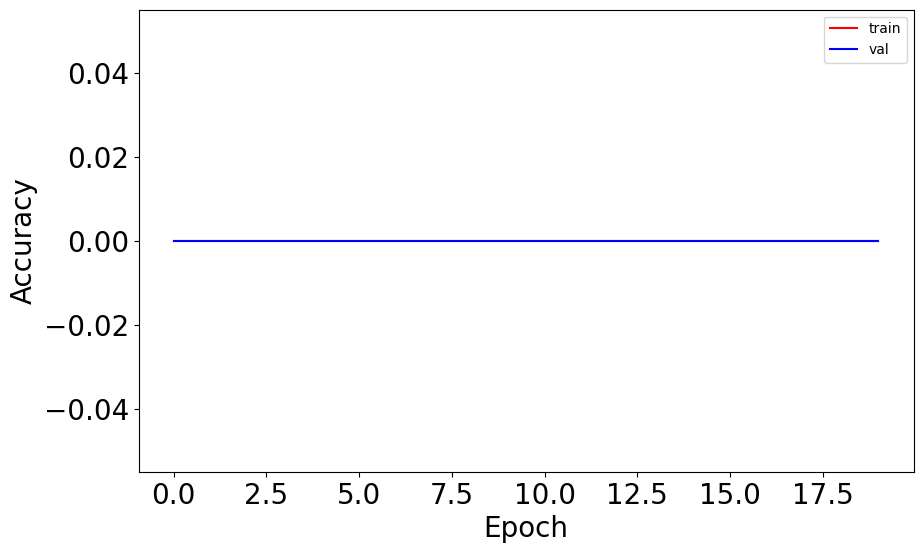

In [61]:
print(losses.history.keys())

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(losses.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(losses.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)